<a href="https://colab.research.google.com/github/viniciusrpb/cloud_image_segmentation/blob/main/cloud_classification_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 12.2 MB/s 


In [3]:
!cp -r "/content/drive/My Drive/img_satelite/classificacao/CCSN/train" "training"
!cp -r "/content/drive/My Drive/img_satelite/classificacao/CCSN/val" "validation"
!cp -r "/content/drive/My Drive/img_satelite/classificacao/CCSN/test" "testing"

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D ,MaxPooling2D,Activation,Flatten,Conv2D,BatchNormalization,Dropout
from tensorflow.keras import layers
from tensorflow.keras import Model
import keras.applications
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import os
import argparse


In [5]:
path_train = 'training'
path_validation = 'validation'
path_test = 'testing'

# Pretrained GoogLeNet model using ImageNet


Hyperparameters

In [6]:
batch_size = 32
epochs=30
dim = (224,224)

In [7]:
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

#pre_trained_model = InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet')
pre_trained_model = ResNet50(input_shape=(224,224,3),include_top=False,pooling ='avg',weights='imagenet', classes=11)

for layer in pre_trained_model.layers:
  layer.trainable = False

94781440/94765736 [==============================] - 2s 0us/step


### Data augmentation

In [8]:
train_datagen = ImageDataGenerator(rescale=1. / 255)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)


Read the images

In [9]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(path_train,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', 
                                                    target_size = (224,224))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  validation_datagen.flow_from_directory( path_validation,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical', 
                                                          target_size = (224,224))

test_generator =  test_datagen.flow_from_directory( path_test,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical', 
                                                          target_size = (224,224))

Found 1774 images belonging to 11 classes.
Found 250 images belonging to 11 classes.
Found 519 images belonging to 11 classes.


Hyper-parameters

In [10]:
number_of_neurons = 1024
number_of_classes = 11

Lets see some samples

In [11]:
model = Sequential()

model.add(pre_trained_model)
model.add(BatchNormalization())
#model.add(GlobalAveragePooling2D())
#model.add(Flatten())

# 1st hidden layer: 300 neurons
#model.add(Dense(number_of_neurons,activation="relu"))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# 2nd hidden layer : 150 neurons
#model.add(Dense(number_of_neurons//2,activation="relu"))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())


# 3rd hidden layer : 75 neurons
#model.add(Dense(number_of_neurons,activation="relu"))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())

model.add(Dense(number_of_classes,activation="softmax"))

In [12]:
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

f1_score = tfa.metrics.F1Score(num_classes=number_of_classes, average='macro',threshold=0.5)

model.compile(optimizer = sgd, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy',f1_score])

#model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005,decay = 1e-6), 
#              loss = 'categorical_crossentropy', 
#              metrics = ['accuracy',f1_score])
            #metrics = ['accuracy',f1_score])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Callbacks definition to reduce chances of overfitting the model

In [13]:
fname = "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

resnet_checkpoint = ModelCheckpoint(fname, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

resnet_early_stopping = EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]

In [14]:
history_fine = model.fit(train_generator,
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=validation_generator,
                         callbacks=callbacklist
                         )

Epoch 1/30
222/222 [==============================] - ETA: 0s - loss: 2.3298 - accuracy: 0.2120 - f1_score: 0.0824
Epoch 1: val_accuracy improved from -inf to 0.12000, saving model to weights-improvement-01-0.12.hdf5
222/222 [==============================] - 43s 106ms/step - loss: 2.3298 - accuracy: 0.2120 - f1_score: 0.0824 - val_loss: 2.4316 - val_accuracy: 0.1200 - val_f1_score: 0.0061 - lr: 0.0100
Epoch 2/30
222/222 [==============================] - ETA: 0s - loss: 2.1282 - accuracy: 0.2892 - f1_score: 0.1422
Epoch 2: val_accuracy improved from 0.12000 to 0.27200, saving model to weights-improvement-02-0.27.hdf5
222/222 [==============================] - 21s 96ms/step - loss: 2.1282 - accuracy: 0.2892 - f1_score: 0.1422 - val_loss: 2.1936 - val_accuracy: 0.2720 - val_f1_score: 0.0375 - lr: 0.0100
Epoch 3/30
222/222 [==============================] - ETA: 0s - loss: 2.0088 - accuracy: 0.3061 - f1_score: 0.1530
Epoch 3: val_accuracy improved from 0.27200 to 0.30400, saving model to

In [15]:
#f1 = history_fine.history['f1_score']
#val_f1 = history_fine.history['val_f1_score']

#plt.figure(figsize=(8, 8))
#plt.subplot(2, 1, 1)
#plt.plot(f1, label='Training F1-Score')
#plt.plot(val_f1, label='Validation F1-Score')
#plt.legend(loc='lower right')
#plt.ylabel('F1-Score')
#plt.ylim([min(plt.ylim()),1])
#plt.title('Training and Validation F1-Score')


Text(0.5, 1.0, 'Training and Validation F1-Score')

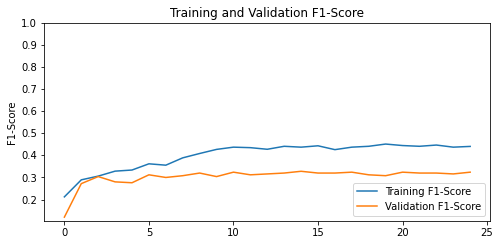

In [16]:
f1 = history_fine.history['accuracy']
val_f1 = history_fine.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(f1, label='Training F1-Score')
plt.plot(val_f1, label='Validation F1-Score')
plt.legend(loc='lower right')
plt.ylabel('F1-Score')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation F1-Score')


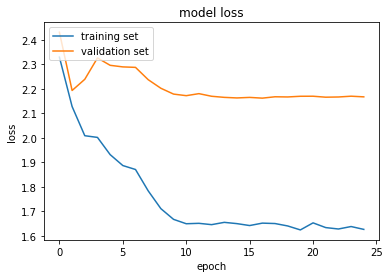

In [17]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper left')
plt.show()

In [18]:
score = model.evaluate(test_generator,batch_size=batch_size) 
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

65/65 [==============================] - 6s 94ms/step - loss: 2.0271 - accuracy: 0.3006 - f1_score: 0.1495
Test loss: 2.0271029472351074 / Test accuracy: 0.3005780279636383


In [19]:
#y_prob = model.predict(test_generator,batch_size=batch_size)
#y_pred = np.argmax(y_prob,axis=1)

y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)
#print(pred, labels[np.argmax(pred)])
print(classification_report(test_generator.classes,y_pred))

              precision    recall  f1-score   support

           0       0.07      0.04      0.05        45
           1       0.03      0.03      0.03        39
           2       0.14      0.20      0.17        49
           3       0.08      0.11      0.09        55
           4       0.00      0.00      0.00        29
           5       0.07      0.08      0.08        59
           6       0.08      0.07      0.08        40
           7       0.04      0.03      0.03        37
           8       0.13      0.16      0.14        56
           9       0.16      0.17      0.17        69
          10       0.00      0.00      0.00        41

    accuracy                           0.09       519
   macro avg       0.07      0.08      0.08       519
weighted avg       0.08      0.09      0.09       519



In [20]:
y_prob

array([[0.05418596, 0.02913554, 0.05919526, ..., 0.0539182 , 0.2974763 ,
        0.2830421 ],
       [0.06255924, 0.08074959, 0.02511758, ..., 0.17135175, 0.12520851,
        0.05751157],
       [0.15882005, 0.07734755, 0.05237953, ..., 0.3370873 , 0.05342315,
        0.18375361],
       ...,
       [0.11218459, 0.0068172 , 0.01223054, ..., 0.01752619, 0.0009933 ,
        0.01494132],
       [0.0432178 , 0.06615105, 0.03787363, ..., 0.11451541, 0.11180068,
        0.08342949],
       [0.06557838, 0.0513603 , 0.0464822 , ..., 0.04803155, 0.03777659,
        0.06530989]], dtype=float32)

In [21]:
test_generator.classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [22]:
y_pred

array([ 9,  6,  8,  9,  0,  9,  4,  5,  6,  6,  5,  5,  3,  9,  2,  8,  7,
        3,  5,  3,  9,  5,  7,  2,  9,  5,  3,  3,  3,  8,  5,  7,  8,  3,
        5,  5,  3,  8,  5,  2,  0,  4,  2,  8,  6,  4,  7,  2,  8,  5,  4,
        9,  8,  8,  8,  5,  3,  3,  5,  1,  9,  8,  3,  9,  6,  2,  3,  3,
        5,  0,  9,  7,  2,  5,  5,  5,  3,  5,  6,  3,  8,  5,  8,  2,  6,
       10,  5,  6,  2,  2,  0,  9,  7,  9,  8,  2,  3, 10,  5,  1,  5,  8,
        6,  7,  3,  3,  6,  7,  2,  2, 10,  2,  9,  0,  8,  1,  9,  3,  1,
        0,  0,  0,  6,  2,  3,  2,  8, 10,  8,  2,  8,  9,  2,  6,  3,  2,
        5, 10,  8,  3,  2,  0,  2,  5,  8,  8,  8,  6,  9,  9,  5,  8,  5,
        0,  1,  1,  9,  3,  8,  5,  0,  9, 10,  2,  8,  3,  9,  9,  0,  1,
        2,  9,  0,  9,  6,  4,  3,  2,  0,  9,  6,  2,  1,  3,  8,  6,  8,
        9,  5,  5,  6,  9,  2,  2,  2,  6,  2,  8,  0,  8,  8,  9, 10, 10,
        1, 10,  3,  8,  5,  2,  2,  7, 10, 10,  5,  5,  8,  3,  3,  8,  3,
        8,  2,  9,  8,  7

In [23]:
import plotly.figure_factory as ff

y_true = test_generator.classes

z = confusion_matrix(y_true, y_pred)

x = list(test_generator.class_indices.keys())

y = list(test_generator.class_indices.keys())


In [24]:
# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()